In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['axes.facecolor'] = 'lightgray'
np.set_printoptions(precision=3)
sns.set(style="darkgrid")

# local util packages
import util

In [2]:
def boxplot_all_methods(plt_handle, res_all, title='', names=[], colors=[], ylim_option=0):   
    res_all_df = pd.DataFrame(res_all.T)
    res_all_df.columns = names
    res_all_df_melt = res_all_df.melt(var_name='methods', value_name='MSE')
    res_all_mean = np.mean(res_all, axis=1)
    
    plt_handle.set_title(title, fontsize=20)

    plt_handle.axhline(res_all_mean[1], ls='--', color='b')
    plt_handle.axhline(res_all_mean[0], ls='--', color='r')
    ax = sns.boxplot(x="methods", y="MSE", data=res_all_df_melt,
                     palette=colors,
                     ax=plt_handle)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=-70, ha='left', fontsize=20)
    ax.tick_params(labelsize=20)
#     ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.2f'))
    ax.yaxis.grid(False) # Hide the horizontal gridlines
    ax.xaxis.grid(True) # Show the vertical gridlines
#     ax.xaxis.set_visible(False)
    ax.set_xlabel("")
    ax.set_ylabel("MSE", fontsize=20)

    if ylim_option == 1:
        lower_ylim = res_all_mean[0] -  (res_all_mean[1] - res_all_mean[0]) *0.3
        # upper_ylim = max(res_all_mean[1] + (res_all_mean[1] - res_all_mean[0]) *0.3, res_all_mean[0]*1.2)
        upper_ylim = res_all_mean[1] + (res_all_mean[1] - res_all_mean[0]) *0.3
        # get the boxes that are outside of the plot
        outside_index = np.where(res_all_mean >  upper_ylim)[0]
        for oindex in outside_index:
            ax.annotate("box\nbeyond\ny limit", xy=(oindex - 0.3, upper_ylim - (upper_ylim-lower_ylim)*0.15 ), fontsize=15)
        plt_handle.set_ylim(lower_ylim, upper_ylim)

In [3]:
# categories used as environments
categories = [
              'Arts_Crafts_and_Sewing_5', 'Automotive_5', 'CDs_and_Vinyl_5',
              'Cell_Phones_and_Accessories_5', 'Digital_Music_5',
              'Grocery_and_Gourmet_Food_5', 'Industrial_and_Scientific_5', 'Luxury_Beauty_5',
              'Musical_Instruments_5', 'Office_Products_5',
              'Patio_Lawn_and_Garden_5', 'Pet_Supplies_5', 'Prime_Pantry_5',
              'Software_5', 'Tools_and_Home_Improvement_5', 'Toys_and_Games_5']
M = len(categories)
print("M=%d" %M)

M=16


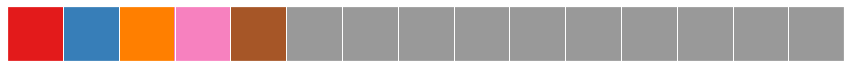

In [4]:
COLOR_PALETTE1 = sns.color_palette("Set1", 9, desat=1.)
COLOR_PALETTE = [COLOR_PALETTE1[k] for k in [0, 1, 4, 7, 6] + [8] * 10]
sns.palplot(COLOR_PALETTE)

In [5]:
def amazon_read_res(target):
    nb_tar_subs = 10
    
    nb_ba = 2
    lamL2s = [10.**(k) for k in (np.arange(10)-5)]

    results_src_ba = np.zeros((len(lamL2s), M-1, nb_ba, 2, 10))
    results_tar_ba = np.zeros((len(lamL2s), 1, nb_ba, 2, 10))
    results_tar_sub_ba = np.zeros((len(lamL2s), 1, nb_ba, nb_tar_subs, 10))

    for k, lamL2 in enumerate(lamL2s):
        for myseed in range(10):
            savefilename = "results_amazon/amazon_review_data_2018_N10000_%s_minDf%s_lamL2%s_lamMatch%s_lamCIP0.1_target%d_seed%d.npy" %('baseline',
                                                   0.008, lamL2, 1., target, myseed)
            res_all_ba = np.load(savefilename, allow_pickle=True)
            results_tar_sub_ba[k, 0, :, :, myseed]  = res_all_ba.item()['tar_sub']
            results_src_ba[k, :, :, :, myseed] = res_all_ba.item()['src'][:, :, :]
            results_tar_ba[k, 0, :, :, myseed] = res_all_ba.item()['tar'][:, :]
    
    lamMatches = [10.**(k) for k in (np.arange(10)-5)]

    nb_damean = 5
    
    results_src_damean = np.zeros((len(lamMatches), M-1, nb_damean, 2, 10))
    results_tar_damean = np.zeros((len(lamMatches), 1, nb_damean, 2, 10))
    results_tar_sub_damean = np.zeros((len(lamMatches), 1, nb_damean, nb_tar_subs, 10))

    for myseed in range(10):
        for k, lam in enumerate(lamMatches):

            savefilename = "results_amazon/amazon_review_data_2018_N10000_%s_minDf%s_lamL2%s_lamMatch%s_lamCIP0.1_target%d_seed%d.npy" %('DAmean',
                                                    0.008, 1.0, lam, target, myseed)
            res_all_damean = np.load(savefilename, allow_pickle=True)
    #         print(res_all_damean.item()['minDiffIndx'])
            results_tar_sub_damean[k, 0, :, :, myseed]  = res_all_damean.item()['tar_sub']
            results_src_damean[k, :, :, :, myseed] = res_all_damean.item()['src'][:, :, :]
            results_tar_damean[k, 0, :, :, myseed] = res_all_damean.item()['tar'][:, :]
            
    

    labeledsize_list = res_all_damean.item()['labeledsize_list']
    
    # choose lambda based on the source test performance
    lam_index_damean = np.zeros(nb_damean, dtype=int)
    for i in range(nb_damean):
        src_test_acc_all = np.mean(np.min(results_src_damean[:, :, i, 1, :], axis=1), axis=1)
        print(src_test_acc_all)
        # choose the largest lambda such that the source performance does not drop too much (1%)
        # Note that 1% is problem-dependent here. 
        # It might be useful to visualize the source performance as a function of lambda
        lam_index = 0
        for k, src_test_acc in enumerate(src_test_acc_all):
            if src_test_acc > np.max(src_test_acc_all) * 0.99:
                lam_index = k
        lam_index_damean[i] = lam_index
        print(lam_index, lamMatches[lam_index])
    
    # now add the methods

    lamL2Index = 4
    results_tar_plot = np.concatenate((results_tar_ba[lamL2Index, 0, :2, 0, :],
                                       results_tar_damean[lam_index_damean[2], 0, 2, 0, :].reshape(1, -1),
                                       results_tar_damean[lam_index_damean[3], 0, 3, 0, :].reshape(1, -1),
                                       results_tar_damean[lam_index_damean[4], 0, 4, 0, :].reshape(1, -1)), axis=0)
    
    
    results_tar_sub_all = np.concatenate((results_tar_sub_ba[lamL2Index, 0, 1:2, :, :].reshape(1, nb_tar_subs, 10),
                                          results_tar_sub_damean[lam_index_damean[2], 0, 2, :, :].reshape(1, nb_tar_subs, 10), 
                                          results_tar_sub_damean[lam_index_damean[3], 0, 3, :, :].reshape(1, nb_tar_subs, 10),
                                          results_tar_sub_damean[lam_index_damean[4], 0, 4, :, :].reshape(1, nb_tar_subs, 10)), axis=0)
    # for tar subs
    tar_sub_min_index = results_tar_sub_all.argmin(axis=0)
    results_tar_sub_plot = np.zeros((nb_tar_subs, 10))
    for i in range(nb_tar_subs):
        for j in range(10):
            method_with_small_tar_sub = tar_sub_min_index[i, j]
            if method_with_small_tar_sub == 0:
                results_tar_sub_plot[i, j] = results_tar_ba[lamL2Index, 0, 1, 0, j]
            else:
                results_tar_sub_plot[i, j] = results_tar_damean[lam_index_damean[1+method_with_small_tar_sub], 0, 1 + method_with_small_tar_sub, 0, j]
            
    results_tar_all_plot = np.concatenate((results_tar_plot, results_tar_sub_plot), axis=0)
    
    return results_tar_plot, results_tar_all_plot, labeledsize_list


In [6]:
names_short = ["Tar", "SrcPool", "DIPweigh", "CIP", "CIRMweigh"]

[0.538 0.538 0.538 0.538 0.538 0.536 0.535 0.535 0.535 0.535]
9 10000.0
[0.453 0.453 0.453 0.452 0.452 0.451 0.451 0.451 0.451 0.451]
9 10000.0
[0.42  0.42  0.42  0.42  0.421 0.421 0.421 0.421 0.421 0.421]
9 10000.0
[0.444 0.444 0.444 0.444 0.444 0.444 0.444 0.444 0.444 0.444]
9 10000.0
[0.42  0.42  0.42  0.42  0.42  0.421 0.421 0.421 0.421 0.421]
9 10000.0


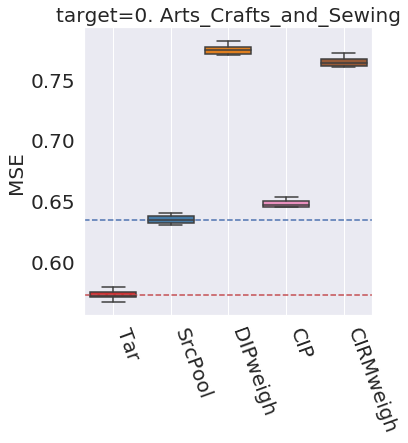

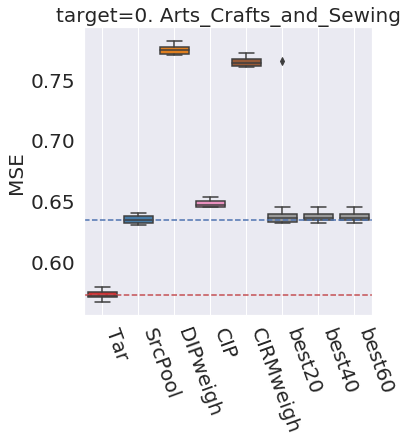

[0.453 0.453 0.453 0.452 0.452 0.451 0.451 0.451 0.451 0.451]
9 10000.0
[0.538 0.538 0.538 0.538 0.538 0.536 0.535 0.535 0.535 0.535]
9 10000.0
[0.42  0.42  0.42  0.421 0.421 0.422 0.422 0.422 0.422 0.422]
9 10000.0
[0.442 0.442 0.442 0.442 0.442 0.442 0.442 0.442 0.442 0.442]
9 10000.0
[0.42  0.42  0.42  0.42  0.421 0.421 0.421 0.421 0.421 0.421]
9 10000.0


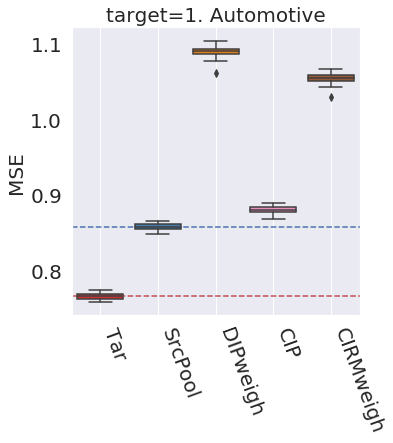

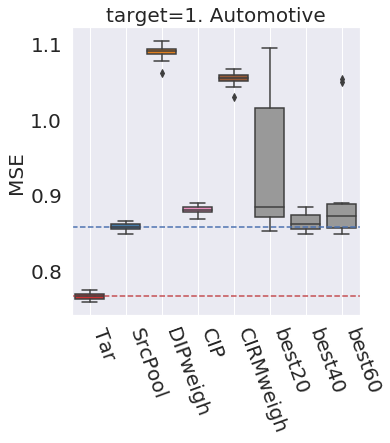

[0.453 0.453 0.452 0.449 0.448 0.448 0.448 0.448 0.448 0.448]
9 10000.0
[0.459 0.459 0.459 0.46  0.46  0.462 0.462 0.462 0.462 0.462]
9 10000.0
[0.42  0.42  0.42  0.421 0.422 0.429 0.433 0.433 0.433 0.433]
9 10000.0
[0.444 0.444 0.444 0.444 0.444 0.444 0.444 0.444 0.444 0.444]
9 10000.0
[0.42  0.42  0.42  0.42  0.421 0.424 0.425 0.426 0.426 0.426]
9 10000.0


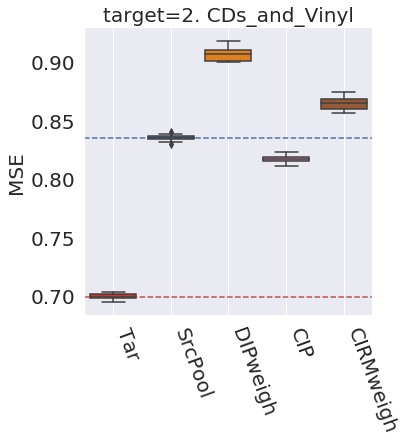

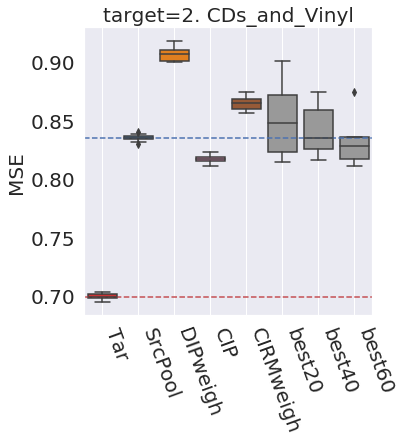

[0.453 0.453 0.453 0.452 0.452 0.452 0.452 0.452 0.452 0.452]
9 10000.0
[0.675 0.675 0.675 0.676 0.682 0.699 0.706 0.707 0.707 0.707]
9 10000.0
[0.42  0.42  0.42  0.421 0.421 0.422 0.422 0.422 0.422 0.422]
9 10000.0
[0.439 0.439 0.439 0.439 0.439 0.439 0.439 0.439 0.439 0.439]
9 10000.0
[0.42  0.42  0.42  0.42  0.421 0.421 0.421 0.421 0.421 0.421]
9 10000.0


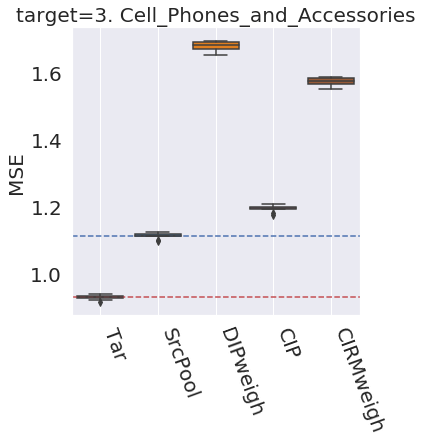

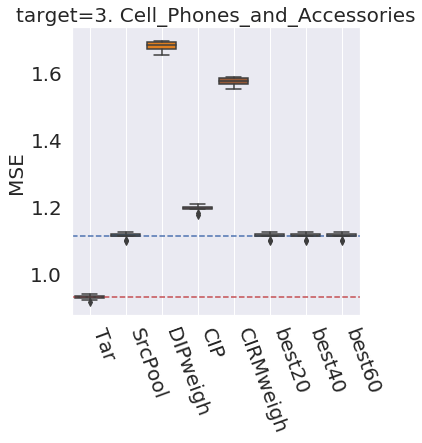

[0.639 0.639 0.639 0.639 0.639 0.639 0.639 0.639 0.639 0.639]
9 10000.0
[0.712 0.712 0.712 0.712 0.714 0.718 0.719 0.719 0.719 0.719]
9 10000.0
[0.644 0.644 0.644 0.644 0.644 0.644 0.644 0.644 0.644 0.644]
9 10000.0
[0.632 0.632 0.632 0.632 0.632 0.632 0.632 0.632 0.632 0.632]
9 10000.0
[0.644 0.644 0.644 0.644 0.644 0.644 0.644 0.644 0.644 0.644]
9 10000.0


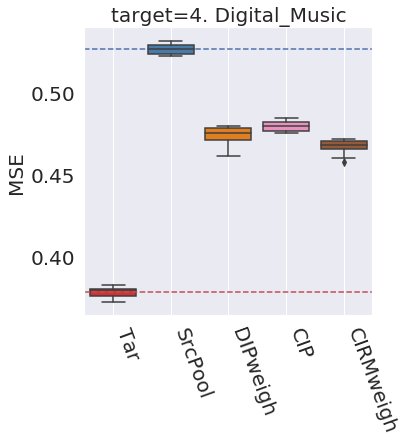

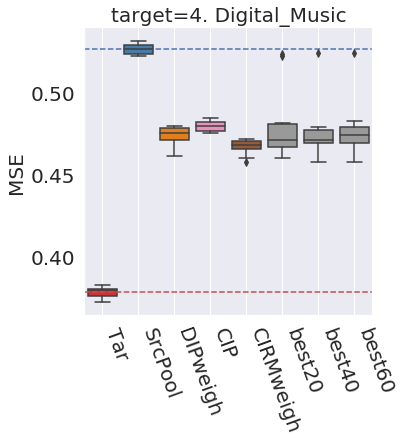

[0.453 0.453 0.453 0.452 0.452 0.451 0.451 0.45  0.45  0.45 ]
9 10000.0
[0.48  0.48  0.48  0.48  0.482 0.485 0.487 0.487 0.487 0.487]
9 10000.0
[0.42  0.42  0.42  0.42  0.421 0.422 0.422 0.422 0.422 0.422]
9 10000.0
[0.443 0.443 0.443 0.443 0.443 0.443 0.443 0.443 0.443 0.443]
9 10000.0
[0.42  0.42  0.42  0.42  0.42  0.421 0.421 0.421 0.421 0.421]
9 10000.0


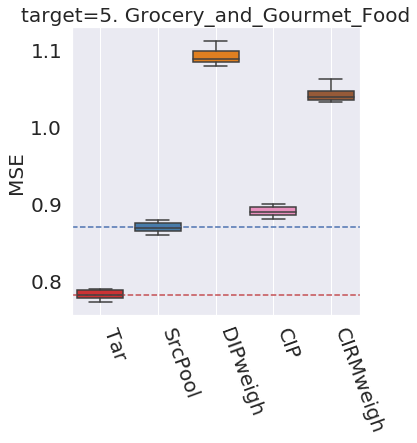

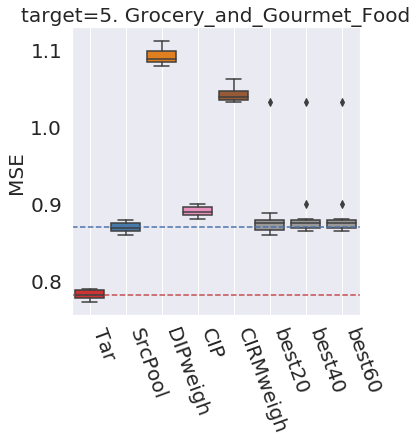

[0.453 0.453 0.453 0.453 0.452 0.452 0.452 0.452 0.452 0.452]
9 10000.0
[0.477 0.477 0.477 0.477 0.479 0.484 0.488 0.489 0.489 0.489]
9 10000.0
[0.42  0.42  0.42  0.421 0.421 0.423 0.423 0.423 0.423 0.423]
9 10000.0
[0.443 0.443 0.443 0.443 0.443 0.443 0.443 0.443 0.443 0.443]
9 10000.0
[0.42  0.42  0.42  0.42  0.421 0.421 0.421 0.421 0.421 0.421]
9 10000.0


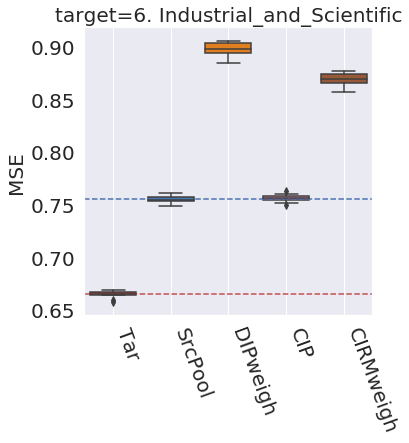

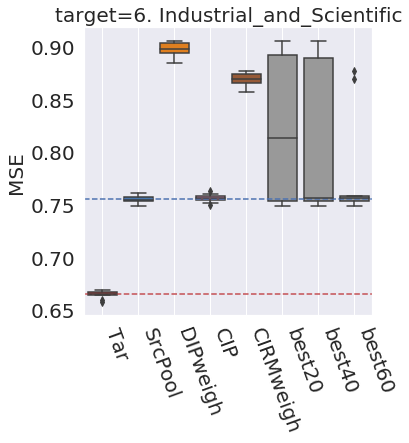

[0.453 0.453 0.453 0.452 0.451 0.451 0.451 0.451 0.451 0.451]
9 10000.0
[0.56  0.56  0.56  0.561 0.567 0.578 0.582 0.582 0.582 0.582]
9 10000.0
[0.42  0.42  0.42  0.421 0.421 0.421 0.421 0.421 0.421 0.421]
9 10000.0
[0.442 0.442 0.442 0.442 0.442 0.442 0.442 0.442 0.442 0.442]
9 10000.0
[0.42  0.42  0.42  0.42  0.42  0.421 0.421 0.421 0.421 0.421]
9 10000.0


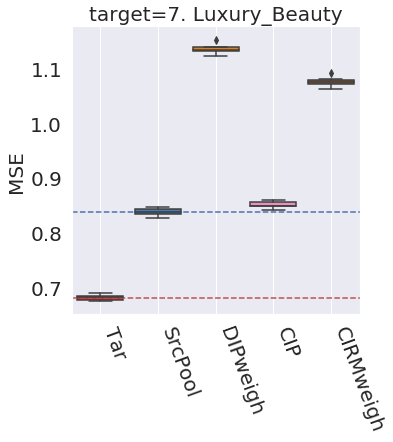

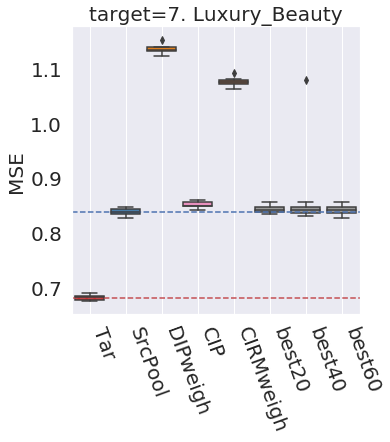

[0.453 0.453 0.453 0.452 0.45  0.451 0.451 0.451 0.451 0.451]
9 10000.0
[0.475 0.475 0.475 0.475 0.477 0.481 0.483 0.483 0.483 0.483]
9 10000.0
[0.42  0.42  0.42  0.421 0.421 0.423 0.423 0.423 0.423 0.423]
9 10000.0
[0.444 0.444 0.444 0.444 0.444 0.444 0.444 0.444 0.444 0.444]
9 10000.0
[0.42  0.42  0.42  0.42  0.421 0.421 0.421 0.421 0.421 0.421]
9 10000.0


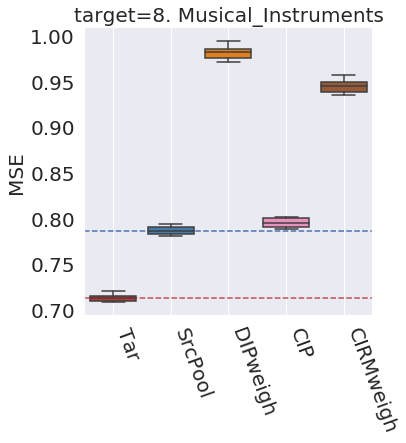

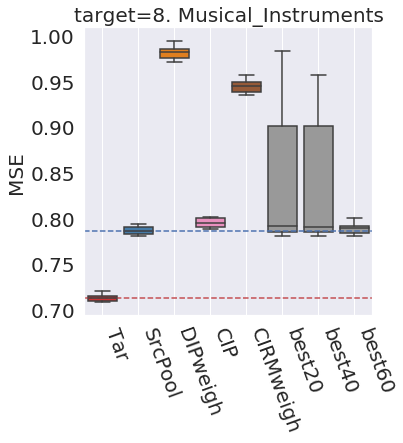

[0.453 0.453 0.453 0.453 0.452 0.452 0.452 0.453 0.453 0.453]
9 10000.0
[0.476 0.476 0.476 0.476 0.477 0.481 0.488 0.489 0.489 0.489]
9 10000.0
[0.42  0.42  0.42  0.421 0.421 0.422 0.422 0.422 0.422 0.422]
9 10000.0
[0.443 0.443 0.443 0.443 0.443 0.443 0.443 0.443 0.443 0.443]
9 10000.0
[0.42  0.42  0.42  0.42  0.421 0.421 0.421 0.421 0.421 0.421]
9 10000.0


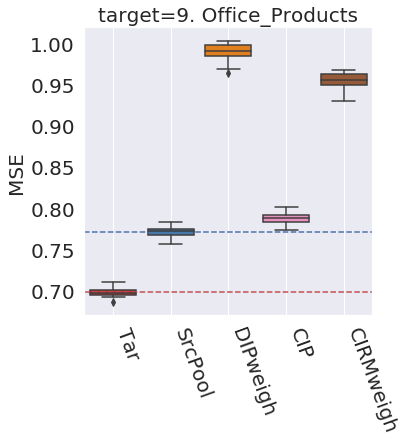

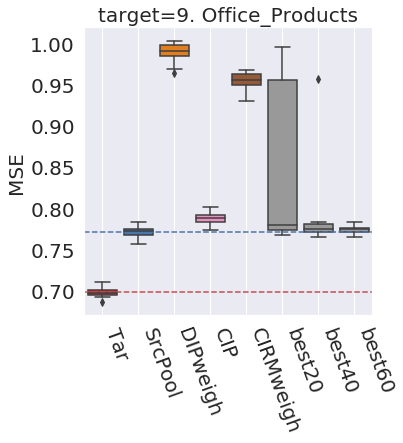

[0.453 0.453 0.453 0.452 0.451 0.449 0.449 0.449 0.449 0.449]
9 10000.0
[0.544 0.544 0.544 0.544 0.547 0.557 0.565 0.566 0.567 0.567]
9 10000.0
[0.42  0.42  0.42  0.421 0.421 0.423 0.423 0.423 0.423 0.423]
9 10000.0
[0.441 0.441 0.441 0.441 0.441 0.441 0.441 0.441 0.441 0.441]
9 10000.0
[0.42  0.42  0.42  0.42  0.421 0.421 0.421 0.421 0.421 0.421]
9 10000.0


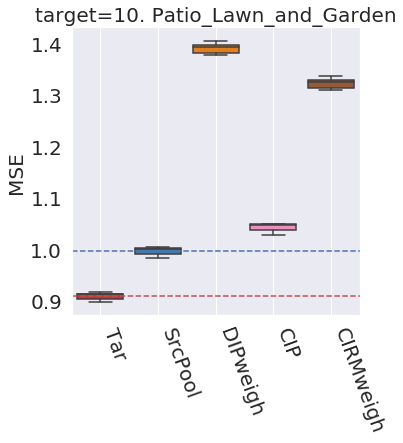

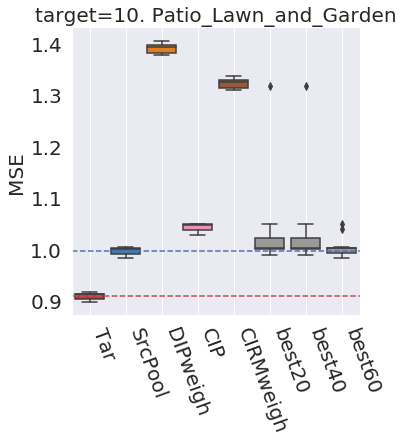

[0.453 0.453 0.453 0.452 0.451 0.451 0.451 0.451 0.451 0.451]
9 10000.0
[0.572 0.572 0.572 0.573 0.577 0.59  0.596 0.597 0.597 0.597]
9 10000.0
[0.42  0.42  0.42  0.421 0.421 0.421 0.421 0.421 0.421 0.421]
9 10000.0
[0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44 0.44]
9 10000.0
[0.42  0.42  0.42  0.42  0.421 0.421 0.421 0.421 0.421 0.421]
9 10000.0


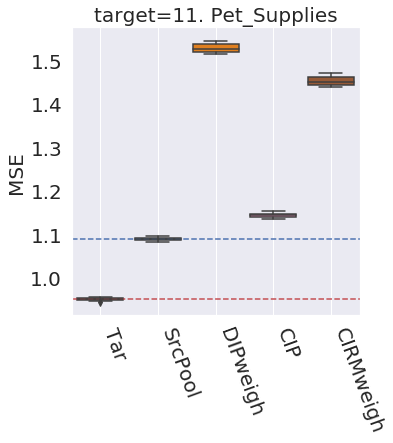

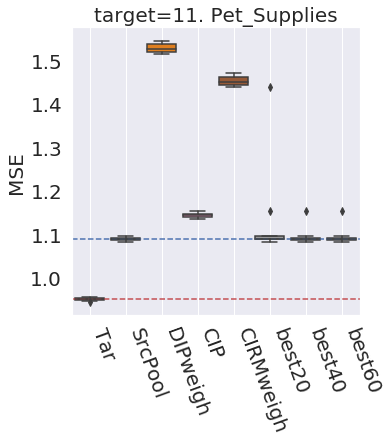

[0.453 0.453 0.453 0.453 0.452 0.451 0.451 0.451 0.451 0.451]
9 10000.0
[0.445 0.445 0.445 0.445 0.445 0.446 0.446 0.446 0.446 0.446]
9 10000.0
[0.42  0.42  0.42  0.42  0.421 0.421 0.421 0.421 0.421 0.421]
9 10000.0
[0.445 0.445 0.445 0.445 0.445 0.445 0.445 0.445 0.445 0.445]
9 10000.0
[0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42]
9 10000.0


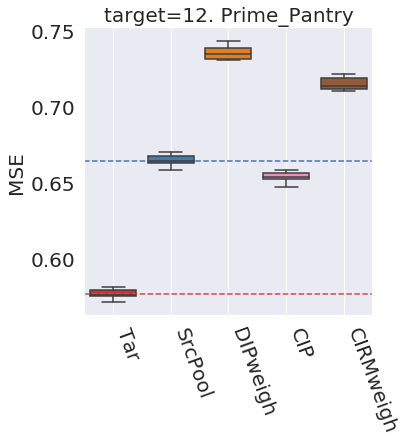

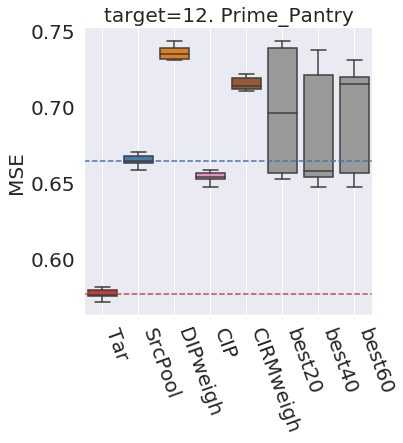

[0.453 0.453 0.452 0.452 0.452 0.452 0.452 0.452 0.452 0.452]
9 10000.0
[0.806 0.806 0.808 0.819 0.899 1.042 1.082 1.087 1.088 1.088]
9 10000.0
[0.42  0.42  0.42  0.421 0.422 0.422 0.422 0.422 0.422 0.422]
9 10000.0
[0.439 0.439 0.439 0.439 0.439 0.439 0.439 0.439 0.439 0.439]
9 10000.0
[0.42  0.42  0.42  0.421 0.421 0.421 0.421 0.421 0.421 0.421]
9 10000.0


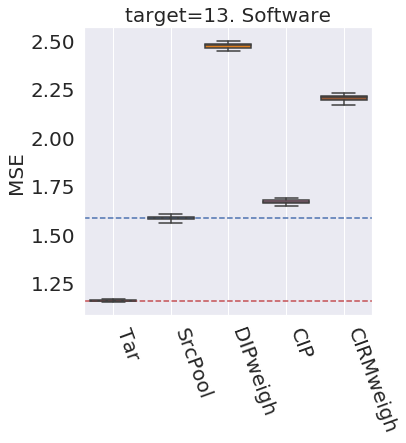

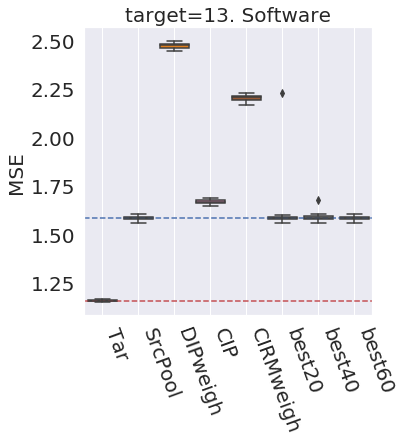

[0.453 0.453 0.453 0.452 0.451 0.45  0.45  0.45  0.45  0.45 ]
9 10000.0
[0.501 0.501 0.501 0.501 0.505 0.517 0.524 0.525 0.525 0.525]
9 10000.0
[0.42  0.42  0.42  0.421 0.421 0.422 0.422 0.422 0.422 0.422]
9 10000.0
[0.442 0.442 0.442 0.442 0.442 0.442 0.442 0.442 0.442 0.442]
9 10000.0
[0.42  0.42  0.42  0.42  0.421 0.421 0.421 0.421 0.421 0.421]
9 10000.0


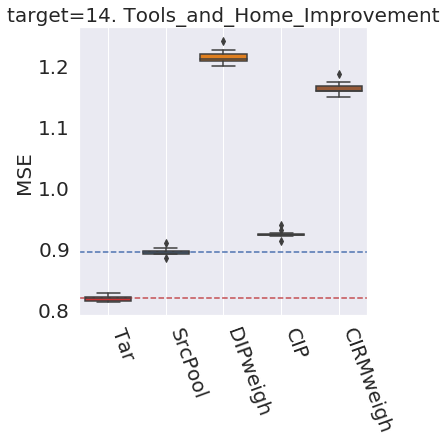

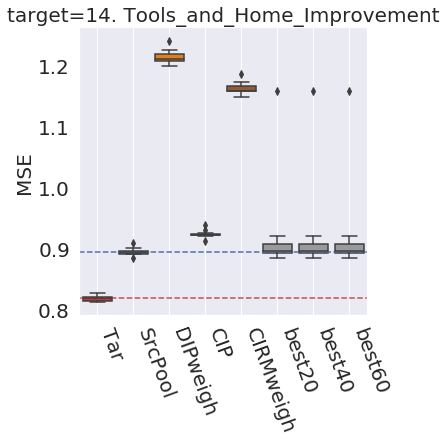

[0.453 0.453 0.453 0.453 0.453 0.452 0.452 0.452 0.452 0.452]
9 10000.0
[0.506 0.506 0.506 0.505 0.505 0.502 0.501 0.501 0.501 0.501]
9 10000.0
[0.42  0.42  0.42  0.42  0.421 0.421 0.421 0.421 0.421 0.421]
9 10000.0
[0.443 0.443 0.443 0.443 0.443 0.443 0.443 0.443 0.443 0.443]
9 10000.0
[0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42]
9 10000.0


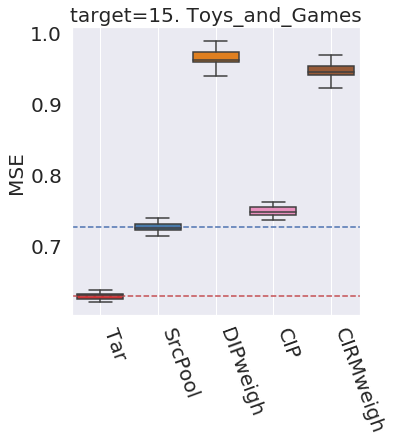

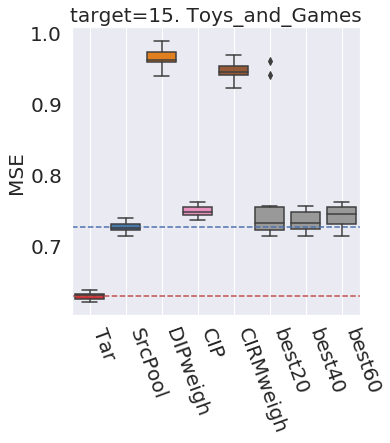

In [7]:
for target in range(M):
    results_tar_plot, results_tar_all_plot, labeledsize_list = amazon_read_res(target)
    
    fig, axs = plt.subplots(1, 1, figsize=(5,5))

    boxplot_all_methods(axs, results_tar_plot, 
                title="target=%d. %s" %(target, categories[target][:-2]), names=names_short, colors=COLOR_PALETTE[:len(names_short)], ylim_option=0)

    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.6,
                            wspace=0.2)
    # plt.savefig("simu_results/paper_figures/sss.pdf" %interv_type, bbox_inches="tight")
    plt.show()
    
    names_all = names_short + ['best%d' %(k)  for k in labeledsize_list]
    
    nb_methods_to_plot = 8
    fig, axs = plt.subplots(1, 1, figsize=(5,5))

    boxplot_all_methods(axs, results_tar_all_plot[:nb_methods_to_plot], 
                title="target=%d. %s" %(target, categories[target][:-2]), names=names_all[:nb_methods_to_plot], colors=COLOR_PALETTE[:nb_methods_to_plot], ylim_option=0)

    plt.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.6,
                            wspace=0.2)
    plt.savefig("paper_figures/amazon/amazon_sub_target%d.pdf" %target, bbox_inches="tight")
    plt.show()
